## 1. Simulation
Simulate the process of magnetization based on 2D Ising model, assume no external magnetic field. Use Metroplolis Algorithm.

In [134]:
from jpype import *
import sys
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
sys.path.append("/Users/qche8799/OneDrive/infodynamics-dist-1.6.1/demos/python")
import readIntsFile
import plotly.graph_objs as go
from plotly.offline import plot
from scipy.signal import savgol_filter
import pandas as pd

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "/Users/qche8799/OneDrive/infodynamics-dist-1.6.1/infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)

# Constant setting
EPSILON = 1e-4

# Plot setting
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cmr10'  # Use the Computer Modern Roman font
plt.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern for math text
plt.rcParams['axes.formatter.use_mathtext'] = True

### Description of process
Consider a set $\Lambda$ of lattice sites in 2D, each site $i$ has a spin $\sigma_i\in\{-1,+1\}$. For each adjacent site $i,j$ there is an interaction $J_{ij}$ between them. Assume interaction strength is the same everywhere in the lattice, and hence $J_{ij}=J$. Consider only energy in the links between the nearest 4 neighbors. Without external magnetic field, the energy of a specific configuration $\underline{\sigma}=\{\sigma_1, ..., \sigma_N\}$ is therefore:

$E(\underline{\sigma}) = -\sum_{<i,j>}{J\sigma_i\sigma_j} = -\sum_{<i,j>}{J\mu_{i,j}}$

Where $<i,j>$ denotes sum over all the adjacent neighbors $i,j$, and $\mu_{i,j}$ represents the interaction between two neighboring sites, with +1 represents alignment and -1 represents misalignment. Note that this formualtion of energy favours alignment between sites (i.e. lower energy when sites are aligned).

The Boltzmann distribution describes the probability of configuration $\underline{\sigma}$ as:

$p_{\beta}(\underline{\sigma}) = \frac{e^{-\beta E(\underline{\sigma})}}{Z_{\beta}}$

Where $\beta = 1/(k_B T)$ is the inverse of temperature.

#### The metropolis algorithm:
This algorithm evolves the system to equilibrium:
1. start with a square NxN lattice
2. randomly choose a site i, now we need to decide wether or not the flip the spin of this site. Let initial energy be E_i and the energy of the flipped state be E_f.
3. if E_i>E_f, flipping results in a lower energy state, hence flip spin(i)
4. if E_i<E_f, the site still has some probability $e^{-\beta(E_f-E_i)}$ of flipping the spin
5. repeat the process from 1

In [2]:
def initialise(N, bias=0.5, seed=0):
    ''' randomly initialise an N*N matrix with {-1,+1}. Bias is the probability of up spins.'''
    np.random.seed(seed)
    config = np.random.choice([1, -1], size=(N, N), p=[bias, 1-bias])
    return config

def get_mu(lattice):
    # mu = -sum<i,j>(sigma_i, sigma_j)
    # applies the nearest neighbours summation, ignore beta*J
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    # total energy should be divided by 2 as each of the neighboring <i,j> pair contributed once to the energy
    return arr.sum()/2

def get_magnetisation(lattice):
    # average spin
    return lattice.sum()/lattice.size

@numba.njit("UniTuple(f8[:], 6)(i8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(lattice, time, J, mu):
    ''' Perform flip on one random site each time, assume beta=1 or T = 1/kB for Boltzmann distribution '''
    beta = 1 # beta = 1/(kB*T), assume temperature is constant 1/kB
    N = lattice.shape[0]

    # save energies and magnetisation for checking
    mus = np.zeros(time)
    magnetisations = np.zeros(time)
    
    # save values for perception-action loop
    spin = np.zeros(time)
    S = np.zeros(time) # sensory values at time t, sum of sigma_i*sigma_j for four neighbours
    A = np.zeros(time) # actions at time t
    SNext = np.zeros(time) # sensory values at time t+1, sum of sigma_i*sigma_j for four neighbours

    for t in range(time):
        mus[t] = mu # net interactions mu = E/J = -sum<i,j>{sigma_i*sigma_j} across the whole lattice
            
        # at each time step, randomly choose a site, compute energy before and after flipping
        x,y = np.random.randint(N), np.random.randint(N)
        spin_i = lattice[x][y] # initial spin
        spin_f = -1*spin_i # spin after flipping
        
        # compute change in Energy/J, E/J=sum<i,j>{-si*sj}
        mu_i = -spin_i*(lattice[x-1][y] + lattice[(x+1)%N][y] + lattice[x][y-1] + lattice[x][(y+1)%N])
        mu_f = -spin_f*(lattice[x-1][y] + lattice[(x+1)%N][y] + lattice[x][y-1] + lattice[x][(y+1)%N])
        dmu = mu_f - mu_i # change in energy after flipping

        S[t] = mu_i # "energy" sensor (senses E/J), when particles align S is negative
        spin[t] = spin_i # sample the spins of a site
        if dmu<0 or np.random.rand()<np.exp(-beta*J*dmu):
            A[t] = -1 # flip the spin
            lattice[x][y] = spin_f
            SNext[t] = mu_f # energy for the chosen site
            mu += dmu # energy in aggregate
        else:
            A[t] = 1 # don't flip the spin
            SNext[t] = mu_i # energy for the chosen site 
        magnetisations[t] = lattice.sum()/lattice.size # magnetisation after action
    return spin, S, A, SNext, mus, magnetisations

def simulation(N, time, J, bias=0.5, seed=0, plot=True):
    # initialise lattice
    lattice = initialise(N, bias, seed)
    
    if plot:
        # run metropolis algorithm and plot the process
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        stepsToPlot = 10**int(np.log10(time)-1) # make a plot for every X number of steps

        # values to keep
        spins = np.array([], dtype=np.int8)
        senses = np.array([],dtype=np.int8)
        actions = np.array([],dtype=np.int8)
        sensesNext = np.array([],dtype=np.int8)
        mus = np.array([])
        magnetisations = np.array([])
    
        for i, ax in enumerate(axes.flatten()):
            if i < 7:
                ax.imshow(lattice, vmin=-1, vmax=1)
                ax.set_title(f'Time = {i*stepsToPlot}')
                sp, s, a, sNext, mu, m = metropolis(lattice, stepsToPlot, J, get_mu(lattice))
            else:
                # for the last one run the rest of the steps and plot
                sp, s, a, sNext, mu, m = metropolis(lattice, time - i*stepsToPlot, J, get_mu(lattice))
                ax.imshow(lattice, vmin=-1, vmax=1)
                ax.set_title(f'Time = {time}')
            spins = np.append(spins, sp)
            senses = np.append(senses, s)
            actions = np.append(actions, a)
            sensesNext = np.append(sensesNext, sNext)
            mus = np.append(mus, mu)
            magnetisations = np.append(magnetisations, m)
    else:
        # just run simulation
        spins, senses, actions, sensesNext, mus, magnetisations = metropolis(lattice, time, J, get_mu(lattice))
    
    return np.int8(spins), np.int8(senses), np.int8(actions), np.int8(sensesNext), mus, magnetisations

/Users/qche8799/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/infodynamics-dist-1.6.1/demos/python/jpype_env/lib/python3.11/site-packages/numba/core/decorators.py:250: RuntimeWarning:

nopython is set for njit and is ignored



## 2. Predictive Information
Compute predictive information and plot values w.r.t. BJ

In [3]:
def mutual_information(source, destination, sourceBase, destinationBase):
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
    calc = calcClass(sourceBase, destinationBase, 0) # use timeDiff = 0
    # 2. No other properties to set for discrete calculators.
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()

    # 4. Supply the sample data:
    # check input dimension:
    if source.ndim >1:
        for k in range(source.shape[1]):
            src = JArray(JInt, 1)(source[:,k].tolist())
            dest = JArray(JInt, 1)(destination[:,k].tolist())
            calc.addObservations(src, dest)
    else:
        src = JArray(JInt, 1)(source.tolist())
        dest = JArray(JInt, 1)(destination.tolist())
        calc.addObservations(src, dest)  
            
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    return result

def entropy(source, sourceBase):
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.discrete").EntropyCalculatorDiscrete
    calc = calcClass(sourceBase)
    # 2. No other properties to set for discrete calculators.
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()

    # 4. Supply the sample data:
    # check input dimension:
    if source.ndim >1:
        for k in range(source.shape[1]):
            # 0. Load/prepare the data:
            src = JArray(JInt, 1)(source[:,k].tolist())
            calc.addObservations(src)
    else:
        src = JArray(JInt, 1)(source.tolist())
        calc.addObservations(src)  
        
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations() #unit = bits
    return result

def conditional_entropy(source, condition, sourceBase, conditionBase):
    entropySource = entropy(source, sourceBase) #H(S)
    miSourceCondition = mutual_information(source, condition, sourceBase, conditionBase) #I(S;C)
    condEntropy = entropySource - miSourceCondition # H(S|C) = H(S) - I(S;C)
    return condEntropy

Check if PI makes sense:
where J is very low (assume beta=1), all the sites starts to jiggle. As J->0, p(flip)->1, and we shall observe $(S_t,S_{t+1}) = (s,-s)$ almost all of the time. $I(S_t,S_{t+1})$ is therefore maximized, and approximately $H(S_t)$ = log2(#values of s) = log2(5) as the majority of sites are internal (i.e. with 4 neigbours), so $\sum_{<i,j>}{\sigma_i\sigma_j}\in\{-4,-2,0,2,4\}$. The conditional entropy is zero in this case.

In [ ]:
# checking if PI makes sense
offset = 4 # convert range [-4,4] to [0,8] for mi computation
base = 2*offset+1
S = senses[-100000:] + offset # take only the last 100k observations
SNext = sensesNext[-100000:] + offset
pi = mutual_information(S, SNext, base, base)
etp = entropy(SNext, base)
condEtp = conditional_entropy(SNext, S, base, base)
print(f'J={J}: predictive information = {pi:.4f} bits, H(SNext) = {etp:.4f} bits, H(SNext|S) = {condEtp:.4f} bits')

## 3. Empowerment
Compute average empowerment (channel capacity) and plot values w.r.t J

### Channel capacity
Considering an arbitrary site i in the lattice. $\sigma_i$ denotes its spin and $\mu_i=\sum_{<i,j>}{-\sigma_i\sigma_j}=\frac{E}{J}$ measures its energy (scaled by a factor J). Lower energy (i.e. negative $\mu$) or equivalently, alignment with neighbors, is preferred.

For this single site, let sensory state $S_t = \mu_i(t)$ and $A_t\in\{flip, no-flip\}$. The action channel of the site is characterised by the conditional probability p(s'|a,s), where s' is the value of the sensory state following an action, given that the site starts from S=s. If $S_t=s$, after flip/no-flip action, the only possible values for $S_{t+1}$ are {s, -s} (except that when s=0 then only one value is possible). Therefore we essentially have a channel looks like {flip, no-flip}$\rightarrow${-s, s}, and the mapping is deterministic. This is the embodiment of the site (agent).

With a binary channel like this, the channel capacity (maximum mutual information max$I(S_{t+1}, A_t)$) C(s)=1 bit, and it's achieved when the distribution between {flip, no-flip} is uniform (50/50 chance). This is true for all values of $s\in\{-4,-3,-2,-1,1,2,3,4\}$. Therefore all these states are equally empowered, if the site is free to designate its action distributions.

The channel capacity of s=0, C(0)=0, because no matter how the site acts (flip or not), it can only perceive s=0. 

Therefore, a more empowered state is where the lattice has net magnetisation $\neq0$, i.e. empoewrment is high when sites are aligned.

Let the subset of S states where channel capacity is nonzero be $\Gamma=\{-4,-3,-2,-1,1,2,3,4\}$. The average empowerment given control parameter J is: $\mathcal{E}(S;J) = \sum{p(s;J)\mathcal{E}(s)}=\sum_{s\in\Gamma}{p(s;J)\times1}$

### Mutual information
On the other hand, we can also compute the actual mutual information (instead of its potential maximum) under the constraint of the "controller" that regulates the action distribution of the site. For a given channel s, the action distribution p(a) is:

- When s < 0: p(flip) = $e^{2\beta Js}$, p(no flip) = 1- p(flip)
- When s >= 0: p(flip) = 1, p(np flip) = 0

Hence mutual information for a given channel s: $I(S_{t+1};A_t|S_t=s) = H(S_{t+1}|S_t=s) - H(S_{t+1}|A_t, S_t=s) = H(S_{t+1}|S_t=s) = -\sum{p*logp}$ (since flip$\rightarrow$-s and no-flip$\rightarrow$s is deterministic, the conditional entropy is zero)

- When s< 0: $I(S_{t+1};A_t|S_t=s) = p(flip)*logp(flip) + p(noflip)*logp(noflip))$ 
- When s>=0: 0

Let the subset of S states where mutual information is nonzero be $\Theta = \{-4,-3,-2,-1\}$. The average mutual information given control parameter J is:
$I(S_{t+1};A_t|J) = \sum{p(s;J)I(S_{t+1};A_t|J,s)} = -\sum_{s\in\Theta}{p(s;J)\{e^{2\beta Js}*log2(e^{2\beta Js}) + (1-e^{2\beta Js})*log2(1-e^{2\beta Js})\}}$ bits

Compared with empowerment, average mutual information gives smaller weight to full alignments $H(S_{t+1}|S=-4) << 1$ when J is large (as we have a very skewed distribution of $S_{t+1}$). The larger is J, the further away is $p(a)$ from optimal $p^*(a)$ (which is 1/2, 1/2)

## 4. Thermodynamic efficiency
$\eta$ describes the amount of work done by changing the control parameter that goes to change the structure of the system, it has a unit of bit/joule. It is defined as follow:
$\eta = \frac{\partial S/\partial X}{\partial W/\partial X} = \frac{\partial S/\partial J}{\int F(J)dJ}$
where S is entropy of the system, X is control parameter, W is work done by changing the control parameter. The denominator is equivalent to integrating fisher information w.r.t the control parameter.

To compute $\eta$, we need the following quantities:

- entropy of system at configuration $S(\underline{\sigma}; J)$, where $\underline{\sigma} = \{\sigma_1, ..., \sigma_{N*N}\}$ $\rightarrow$ computed in section 2
- derivative of entropy w.r.t. J
- Fisher information of control parameter J $F(J) = 4*\sum_{x}{(\frac{\sqrt{p(x;J+\delta J)} - \sqrt{p(x;J-\delta J)}}{2\delta J})^2}$
- integral of fisher information w.r.t. J

In [5]:
# @numba.njit("f8[:](f8[:], f8[:])", nopython=True, nogil=True)
# def get_derivatives(xVals, fxVals):
#     ''' Assume x are equally spaced, compute df/dx.
#     x: numpy array, sorted
#     fx: numpy array
#     Return derv: numpy array
#     '''
#     dx = xVals[1] - xVals[0]
#     derv = np.zeros(len(xVals), dtype=np.float64)
#     for i, x in enumerate(xVals):
#         if i == 0: 
#             derv[i] = (fxVals[i+1] - fxVals[i])/dx #forward difference for the first point
#         elif i == len(xVals) - 1:
#             derv[i] = (fxVals[i] - fxVals[i-1])/dx #backward difference for the last point
#         else:
#             derv[i] = (fxVals[i+1] - fxVals[i-1])/(2*dx) #central difference for all other points
#     return derv

def get_pdf(samples):
    sigma, counts = np.unique(samples, return_counts=True)
    p = {}
    for sig, cnt in zip(sigma, counts):
        p[sig] = cnt/samples.size
    return p

def get_fisher(pdf):
    # density function takes the form f(x;theta), input is a dictionary mapping theta to the corresponding f(x)
    # where theta is the parameter with respect to which we compute the fisher information
    # assume theta is uniformly spaced
    thetas = np.array(list(pdf.keys()))
    fisher = {}

    for i, theta in enumerate(pdf.keys()):
        if i == 0:
            # forward difference for the first theta
            thetaPlus = thetas[i+1]
            dTheta = thetaPlus - theta
            p = pdf[theta] #f(x;J)
            pPlus = pdf[thetaPlus] #f(x;J+dJ)
            allX = set(p.keys()).union(set(pPlus.keys())) # set of all possible sigmas {-1, 1}
            fi = 0
            for x in allX:
                fi = fi + 4 * ((pPlus.get(x,0)**0.5 - p.get(x,0)**0.5)/dTheta)**2 # fi = 4 * sum_x{(d_sqrt(p)/d_theta)^2}
        elif i == len(thetas) - 1:
            # backward difference for the last theta
            thetaMinus = thetas[i-1]
            dTheta = theta - thetaMinus
            p = pdf[theta]
            pMinus = pdf[thetaMinus] #f(x;J-dJ)
            allX = set(p.keys()).union(set(pMinus.keys())) 
            fi = 0
            for x in allX:
                fi = fi + 4 * ((p.get(x,0)**0.5 - pMinus.get(x,0)**0.5)/dTheta)**2
        else:
            # central difference for other thetas
            thetaMinus = thetas[i-1]
            thetaPlus = thetas[i+1]
            dTheta = thetaPlus - thetaMinus
            pMinus = pdf[thetaMinus]
            pPlus = pdf[thetaPlus] 
            allX = set(pPlus.keys()).union(set(pMinus.keys())) 
            fi = 0
            for x in allX:
                fi = fi + 4 * ((pPlus.get(x,0)**0.5 - pMinus.get(x,0)**0.5)/dTheta)**2 
        fisher[theta] = fi    
    return fisher

# def get_integral(xVals, fxVals, start, end):
#     ''' Assume x equally spaced. Find sum_x(fx*dx) within range of integration'''
#     dx = xVals[1] - xVals[0]
#     integral = 0
#     if start < end:
#         integral = dx * fxVals[(xVals>=start) & (xVals<=end)].sum()
#     elif start > end:
#         integral = -dx * fxVals[(xVals<=start) & (xVals>=end)].sum()
#     else:
#         integral = np.nan
#     return integral


## 5. Conditional entropy (active inference intrinsic only)

In [6]:
def get_free_energy(nextSensory, nextEnvironment, action, numBins=10):
    base = 9
    # work out the distribution of different actions
    pA = get_pdf(action)
    # put next environment into bins
    nextEnvDigitized = np.digitize(nextEnvironment, np.linspace(-1,1,numBins), right=True) # put magnetisation [-1,1] into bins
    # compute negative conditional entropy for given A=a, then take the weighted sum across all a
    freeEnergy = 0
    for a in pA.keys():
        SNext = nextSensory[action==a] # already offest to 0-8
        RNext = nextEnvDigitized[action==a] 
        freeEnergy -= pA[a] * conditional_entropy(SNext, RNext, base, numBins)
    return freeEnergy

## 6. Analysis

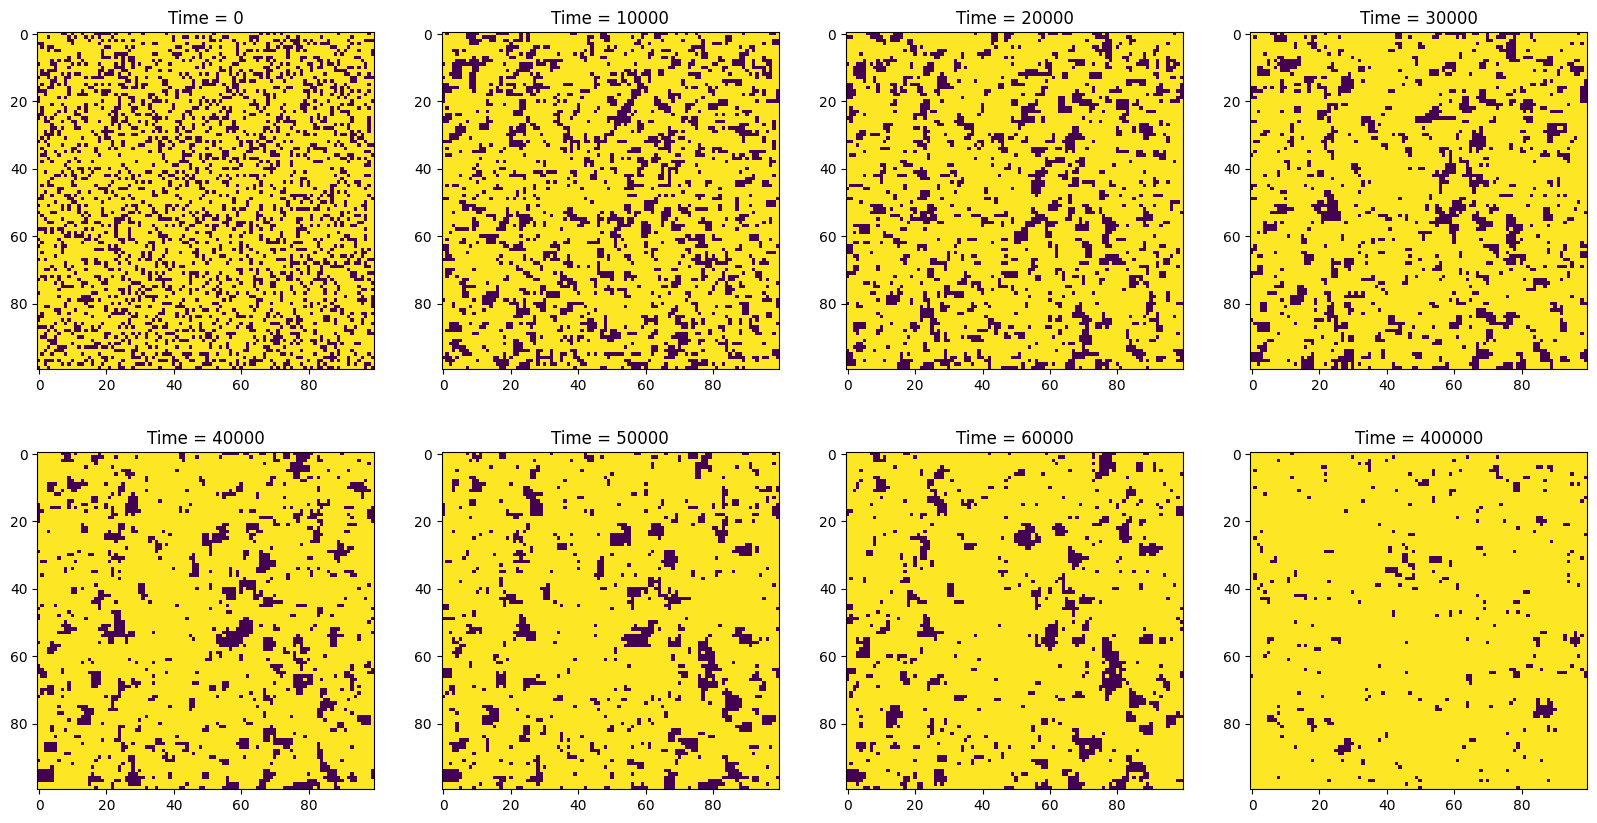

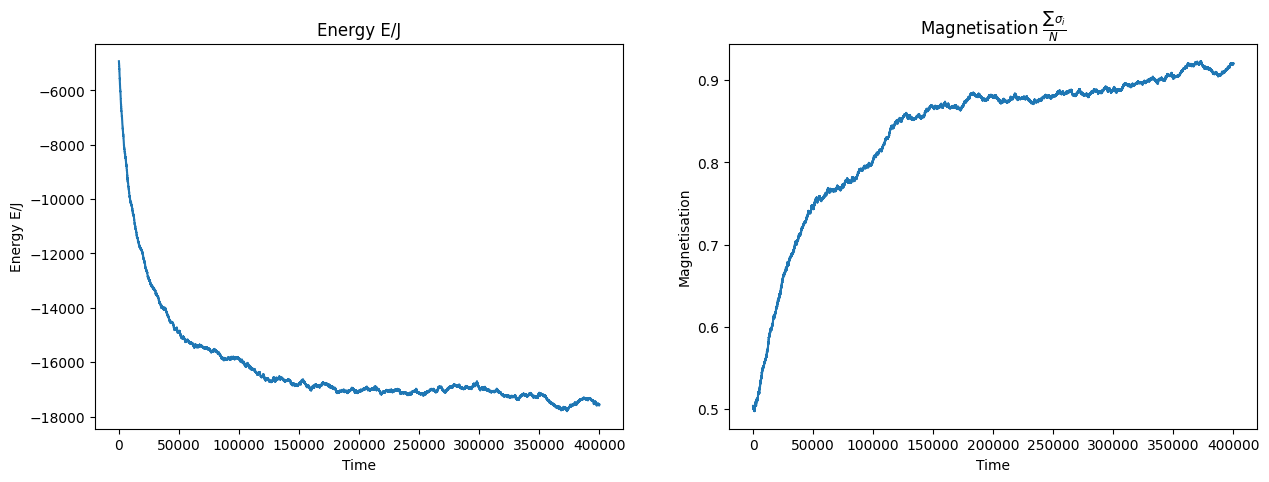

In [7]:
# simulation for one J
N = 100
time = 400000
J = 0.5
spins, senses, actions, sensesNext, mus, magnetisations = simulation(N, time, J, bias=0.75, seed=0)

# plot energy and magnetisation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(range(time), mus);
ax.set_title('Energy E/J');
ax.set_xlabel('Time');
ax.set_ylabel('Energy E/J');
ax = axes[1]
ax.plot(range(time), magnetisations);
ax.set_title(r'Magnetisation $\frac{\sum{\sigma_i}}{N}$');
ax.set_xlabel('Time');
ax.set_ylabel('Magnetisation');
# ax.set_ylim(-1,1)

In [110]:
%%time
# run for multiple J and compute analytical quantities for each J
Js = np.linspace(0.01,2,600)
N = 100
time = 1200000 # perform 1.2mil flips
numSample = 200000 # take 20k observations to compute pi
EPSILON = 1e-6

# for pi
pis = {}
etps = {} # entropy of energy E/J
pdfS = {} # pdf of sensory states

# for empowerment
emps = {}
mis = {}

# for eta
etpSigma = {} # entropy of configuration sigma
pdf = {} # pdf of configuration

# for free energy
fe = {}

# for computing entropy/mutual information
offsetA = 1 # convert [-1,1] to [0,2]
offsetS = 4 # convert [-4,4] to [0,8]
baseA = 2 # [0,1] has base 2
baseS = 9 # [0,8] has base 9

for j in Js:
    # use a small positive bias to break the up/down spin symmetry for configuration entropy
    spins, senses, actions, sensesNext, mus, magnetisations = simulation(N, time, j, bias=0.75, seed=0, plot=False)
    S = senses[-numSample:]
    A = actions[-numSample:]
    SNext = sensesNext[-numSample:] # take the last 100k observations, disregard transient
    
    # compute pi
    pis[j] = mutual_information(S + offsetS, SNext + offsetS, baseS, baseS)
    etps[j] = entropy(SNext + offsetS, baseS)
    pdfS[j] = get_pdf(SNext[-numSample:])
    
    # compute average empowerment (channel capacity) and average mutual information
    emps[j] = sum(SNext!=0)/numSample # all non-zero states are equally empowered
    mis[j] =  mutual_information((A + offsetA)//2, SNext + offsetS, baseA, baseS)
    
    # for computing eta
    Mbar = magnetisations[-numSample:].mean() # average magnetisation over 10k samples at equilibrium
    pdf[j] = {1:(1+Mbar)/2, -1:(1-Mbar)/2}
    etpSigma[j] = 0
    for sig in pdf[j].keys():
        if pdf[j][sig] > EPSILON:
            etpSigma[j] -= pdf[j][sig]*np.log2(pdf[j][sig])

    # for free energy
    fe[j] = get_free_energy(SNext[-numSample:] + offsetS, magnetisations[-numSample:], actions[-numSample:], numBins=10)
    

CPU times: user 48min 7s, sys: 14.3 s, total: 48min 22s
Wall time: 48min 33s


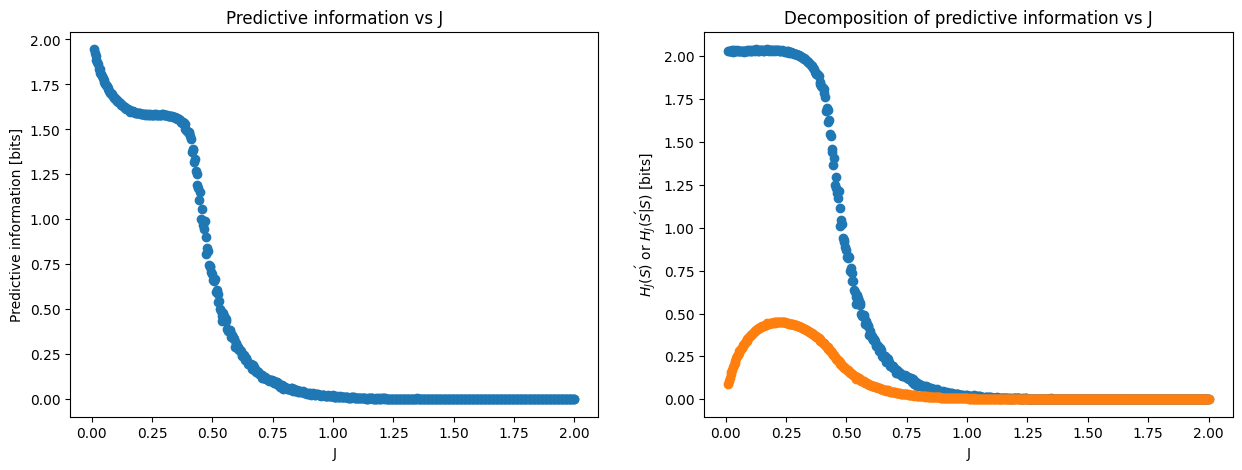

In [111]:
# plots for PI, H(S') and H(S'|S)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.scatter(pis.keys(), pis.values())
ax.set_title('Predictive information vs J');
ax.set_xlabel('J');
ax.set_ylabel('Predictive information [bits]');

ax = axes[1]
ax.scatter(etps.keys(), etps.values(), label=r'entropy $H_J(S\')$')
ax.scatter(etps.keys(), np.array(list(etps.values())) - np.array(list(pis.values())), label=r'conditional entropy H(S\'|S)')
ax.set_title(r'Decomposition of predictive information vs J');
ax.set_xlabel('J');
ax.set_ylabel(r'$H_J(S\')$ or $H_J(S\'|S)$ [bits]');

In [ ]:
# derivative of PI
piDerv = get_derivatives(np.array(list(pis.keys())), np.array(list(pis.values())))
# make interactive plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(pis.keys()), y=piDerv, name='d', mode='lines'))
fig.update_layout(title='Derivative of PI vs J',
                  xaxis_title='J',
                  yaxis_title='dI(S\';S)/dJ',
                  # autosize=False,  
                  # width=7*96,      
                  # height=5*96       
                  )
plot(fig, filename='dervpi.html', auto_open=True) 

In [ ]:
# sensory distribution
# make interactive plot
j = 0.01
J = list(pis.keys())[int((j-0.01) * 500 / (2-0.01))]
fig = go.Figure()
fig = go.Figure(data=[go.Bar(x=list(pdfS[J].keys()), y=list(pdfS[J].values()))])
fig.update_layout(title=f'Distribution of sensory state J={J:.4f}',
                  xaxis_title='Sensory states',
                  yaxis_title='Frequency',
                  bargap=0.2,
                  bargroupgap=0.1
                  # autosize=False,  
                  # width=7*96,      
                  # height=5*96       
                  )
plot(fig, filename='pdfS.html', auto_open=True) 

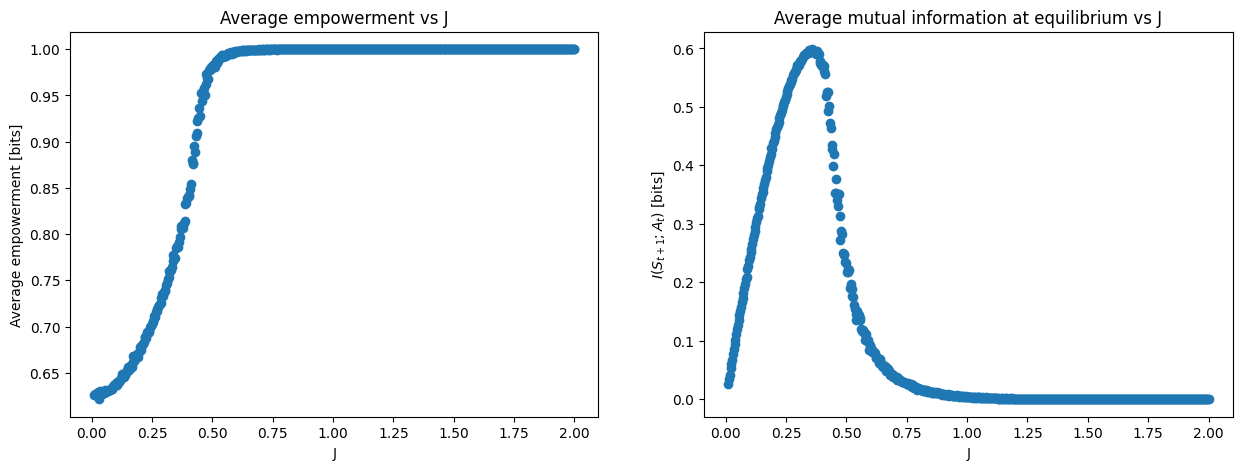

In [112]:
# plots for empowerment
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.scatter(emps.keys(), emps.values())
ax.set_title('Average empowerment vs J');
ax.set_xlabel('J');
ax.set_ylabel('Average empowerment [bits]');

ax = axes[1]
ax.scatter(mis.keys(), mis.values())
ax.set_title('Average mutual information at equilibrium vs J');
ax.set_xlabel('J');
ax.set_ylabel(r'$I(S_{t+1};A_t)$ [bits]');

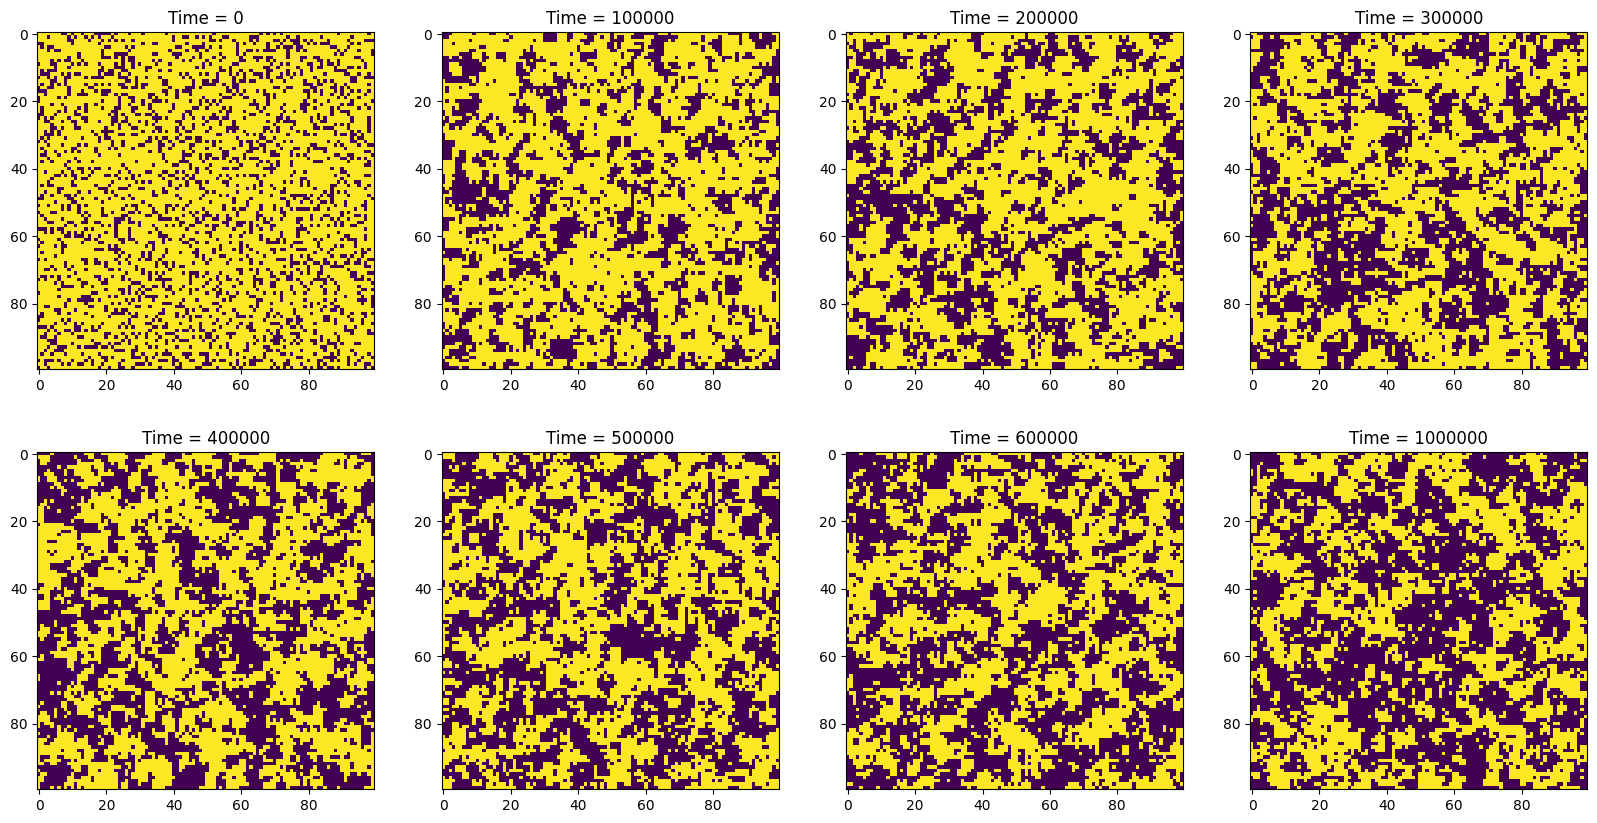

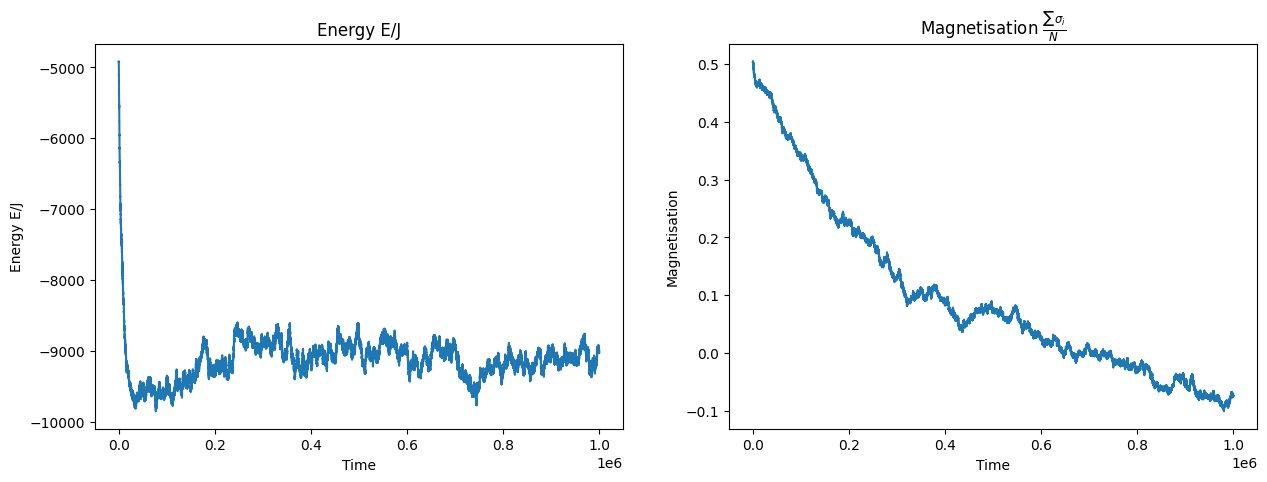

In [113]:
# observe behaviour for average mi optimal
jmax = list(mis.keys())[np.argmax(list(mis.values()))]

N = 100
time = 1000000
spins, senses, actions, sensesNext, mus, magnetisations = simulation(N, time, jmax, bias=0.75, seed=0)

# plot energy and magnetisation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(range(time), mus);
ax.set_title('Energy E/J');
ax.set_xlabel('Time');
ax.set_ylabel('Energy E/J');
ax = axes[1]
ax.plot(range(time), magnetisations);
ax.set_title(r'Magnetisation $\frac{\sum{\sigma_i}}{N}$');
ax.set_xlabel('Time');
ax.set_ylabel('Magnetisation');

In [116]:
def get_eta(configEntropy, fisherInfo, entropyFilt=False, derivativeFilt=False, fisherFilt=False, integralFilt=False, window=14):
    theta = np.array(list(etpSigma.keys()))
    hx = np.array(list(configEntropy.values()))
    fisher = np.array(list(fisherInfo.values()))
    denominator = {}
    
    if entropyFilt:
        hx = savgol_filter(hx, window_length=window, polyorder=1)
    if fisherFilt:
        fisher = savgol_filter(fisher, window_length=window, polyorder=1)
    
    numerator = np.gradient(hx,theta)
    for i,j in enumerate(theta):
        denominator[j] = np.trapz(fisher[i:], theta[i:]) # integrate from theta0 to point to zero-response
    denominator = np.array(list(denominator.values()))
    if derivativeFilt:
        numerator = savgol_filter(numerator, window_length=window, polyorder=1)
    if integralFilt:
        denominator = savgol_filter(denominator, window_length=window, polyorder=1)
    eta = np.where(((abs(denominator)<EPSILON) | (abs(numerator)<EPSILON)), 0, -numerator / denominator)
    etaDict = dict(zip(theta, eta))
    return etaDict, hx, numerator, fisher, denominator

/var/folders/kj/hp7s5d0j3bv2r65lp52n_ywm0000gq/T/ipykernel_27403/1476547138.py:20: RuntimeWarning:

divide by zero encountered in divide

/var/folders/kj/hp7s5d0j3bv2r65lp52n_ywm0000gq/T/ipykernel_27403/1476547138.py:20: RuntimeWarning:

invalid value encountered in divide



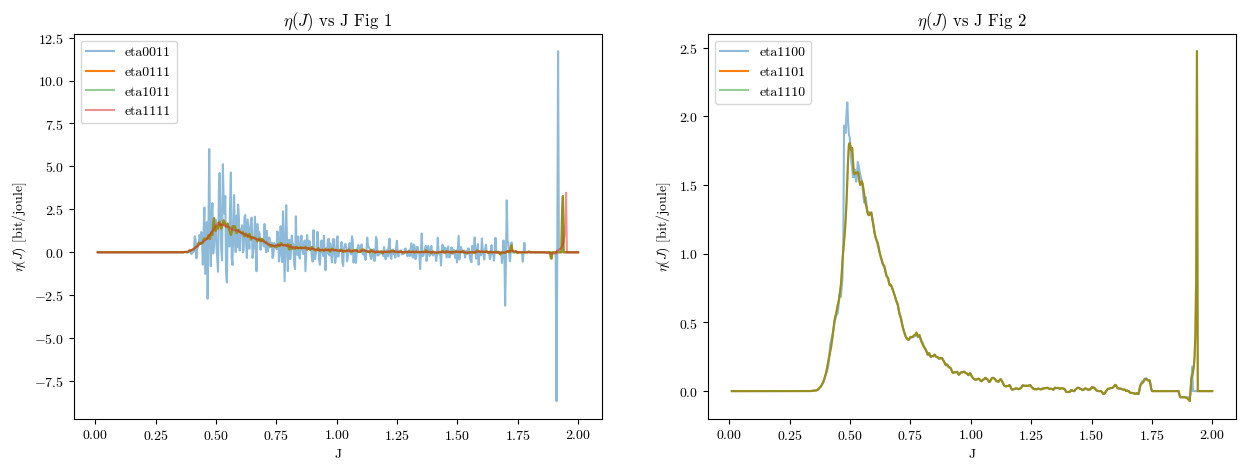

In [135]:
# check filter effect: full on numerator or denominator
fisherInfo = get_fisher(pdf)
eta1100,h1,n11,f0,d00 = get_eta(etpSigma, fisherInfo, entropyFilt=True, derivativeFilt=True, fisherFilt=False, integralFilt=False)
eta1101,_,_,_,d01 = get_eta(etpSigma, fisherInfo, entropyFilt=True, derivativeFilt=True, fisherFilt=False, integralFilt=True)
eta1110,_,_,_,d10 = get_eta(etpSigma, fisherInfo, entropyFilt=True, derivativeFilt=True, fisherFilt=True, integralFilt=False)

eta0011,h0,n00,f1,d11 = get_eta(etpSigma, fisherInfo, entropyFilt=False, derivativeFilt=False, fisherFilt=True, integralFilt=True)
eta0111,_,n01,_,_ = get_eta(etpSigma, fisherInfo, entropyFilt=False, derivativeFilt=True, fisherFilt=True, integralFilt=True)
eta1011,_,n10,_,_ = get_eta(etpSigma, fisherInfo, entropyFilt=True, derivativeFilt=False, fisherFilt=True, integralFilt=True)
eta1111,_,n11,_,_ = get_eta(etpSigma, fisherInfo, entropyFilt=True, derivativeFilt=True, fisherFilt=True, integralFilt=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(eta0011.keys(), eta0011.values(), label='eta0011', alpha=0.5)
ax.plot(eta0111.keys(), eta0111.values(), label='eta0111')
ax.plot(eta1011.keys(), eta1011.values(), label='eta1011', alpha=0.5)
ax.plot(eta1111.keys(), eta1111.values(), label='eta1111', alpha=0.5)
ax.set_title(r'$\eta(J)$ vs J Fig 1');
ax.set_xlabel('J');
ax.set_ylabel(r'$\eta(J)$ [bit/joule]');
ax.legend();

ax = axes[1]
ax.plot(eta1100.keys(), eta1100.values(), label='eta1100', alpha=0.5)
ax.plot(eta1101.keys(), eta1101.values(), label='eta1101')
ax.plot(eta1110.keys(), eta1110.values(), label='eta1110', alpha=0.5)
ax.set_title(r'$\eta(J)$ vs J Fig 2');
ax.set_xlabel('J');
ax.set_ylabel(r'$\eta(J)$ [bit/joule]');
ax.legend();

/var/folders/kj/hp7s5d0j3bv2r65lp52n_ywm0000gq/T/ipykernel_27403/1476547138.py:20: RuntimeWarning:

divide by zero encountered in divide

/var/folders/kj/hp7s5d0j3bv2r65lp52n_ywm0000gq/T/ipykernel_27403/1476547138.py:20: RuntimeWarning:

invalid value encountered in divide



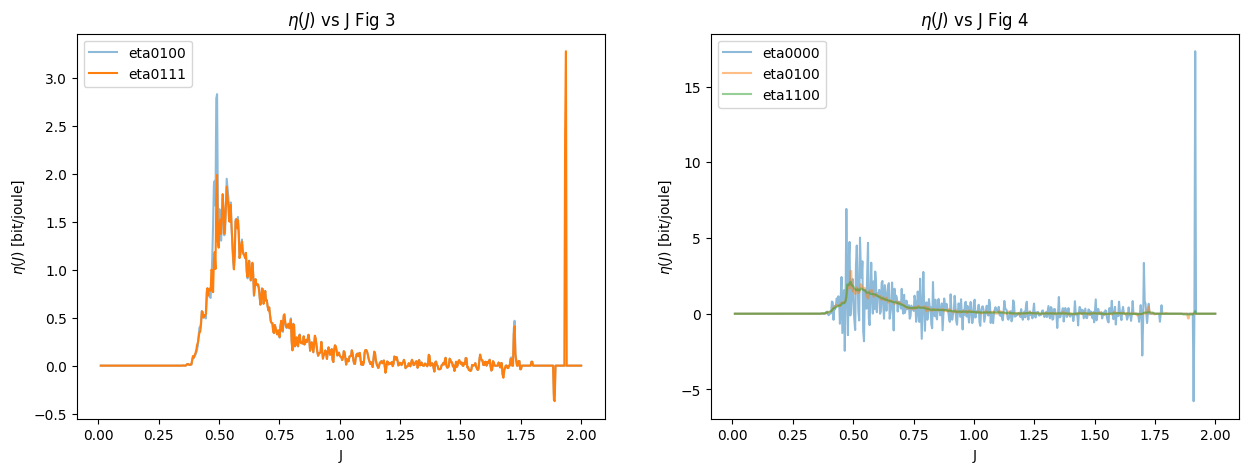

In [118]:
# check filter delay: no filter in denominator
eta0100,_,_,_,_ = get_eta(etpSigma, fisherInfo, entropyFilt=False, derivativeFilt=True, fisherFilt=False, integralFilt=False)
eta1000,_,_,_,_ = get_eta(etpSigma, fisherInfo, entropyFilt=True, derivativeFilt=False, fisherFilt=False, integralFilt=False)
eta0000,_,_,_,_ = get_eta(etpSigma, fisherInfo, entropyFilt=False, derivativeFilt=False, fisherFilt=False, integralFilt=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(eta0100.keys(), eta0100.values(), label='eta0100', alpha=0.5)
ax.plot(eta0111.keys(), eta0111.values(), label='eta0111')
ax.set_title(r'$\eta(J)$ vs J Fig 3');
ax.set_xlabel('J');
ax.set_ylabel(r'$\eta(J)$ [bit/joule]');
ax.legend();

ax = axes[1]
ax.plot(eta0000.keys(), eta0000.values(), label='eta0000', alpha=0.5)
ax.plot(eta0100.keys(), eta0100.values(), label='eta0100', alpha=0.5)
ax.plot(eta1100.keys(), eta1100.values(), label='eta1100', alpha=0.5)

ax.set_title(r'$\eta(J)$ vs J Fig 4');
ax.set_xlabel('J');
ax.set_ylabel(r'$\eta(J)$ [bit/joule]');
ax.legend();

Comments:
- Fig 1: filter on numerator has significant smoothing effect and should not be removed
- Fig 2: filter on denominator magnefies noise in tail
- Fig 3: filter on denominator (integral) causes peak to shift to right, and not much smoothing is gain. => remove filter on denominator completely
- Fig 4 $\eta$ is too noisy when remove filter completely. Filter on derivative alone has similar effect to entropy + derivative. Use filter on derivative alone to reduce delay introduced by compounding filters.

Conclusion: use eta0100

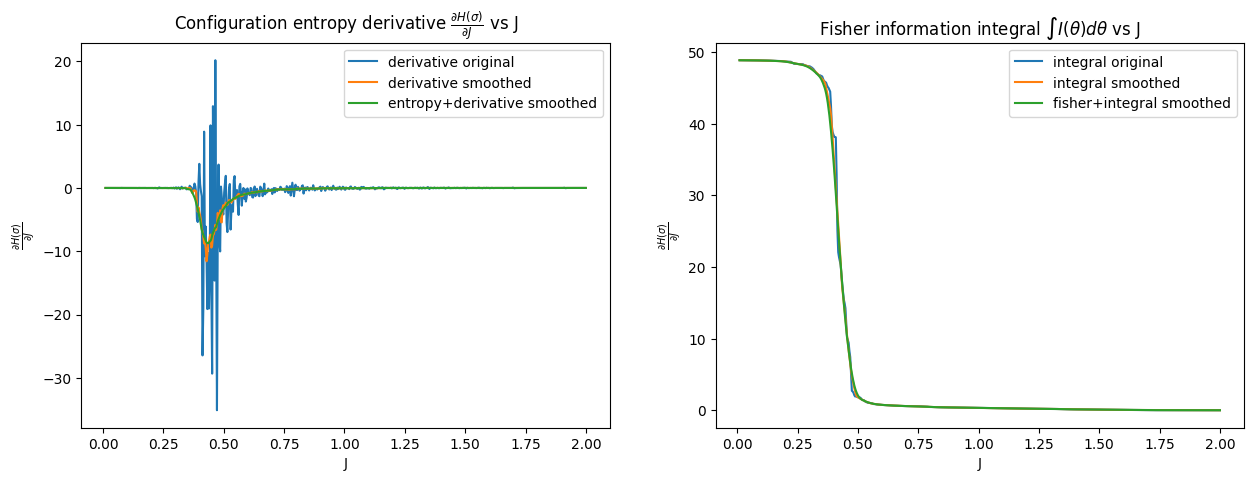

In [119]:
# check filter delay effect for numerator and denominator
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(eta0100.keys(), n00, label='derivative original')
ax.plot(eta0100.keys(), n01, label='derivative smoothed')
ax.plot(eta0100.keys(), n11, label='entropy+derivative smoothed')
ax.set_title(r'Configuration entropy derivative $\frac{\partial H(\sigma)}{\partial J}$ vs J');
ax.set_xlabel('J');
ax.set_ylabel(r'$\frac{\partial H(\sigma)}{\partial J}$');
ax.legend();

ax = axes[1]
ax.plot(eta0100.keys(), d00, label='integral original')
ax.plot(eta0100.keys(), d01, label='integral smoothed')
ax.plot(eta0100.keys(), d11, label='fisher+integral smoothed')
ax.set_title(r'Fisher information integral $\int I(\theta)d\theta$ vs J');
ax.set_xlabel('J');
ax.set_ylabel(r'$\frac{\partial H(\sigma)}{\partial J}$');
ax.legend();

/var/folders/kj/hp7s5d0j3bv2r65lp52n_ywm0000gq/T/ipykernel_27403/1476547138.py:20: RuntimeWarning:

divide by zero encountered in divide

/var/folders/kj/hp7s5d0j3bv2r65lp52n_ywm0000gq/T/ipykernel_27403/1476547138.py:20: RuntimeWarning:

invalid value encountered in divide



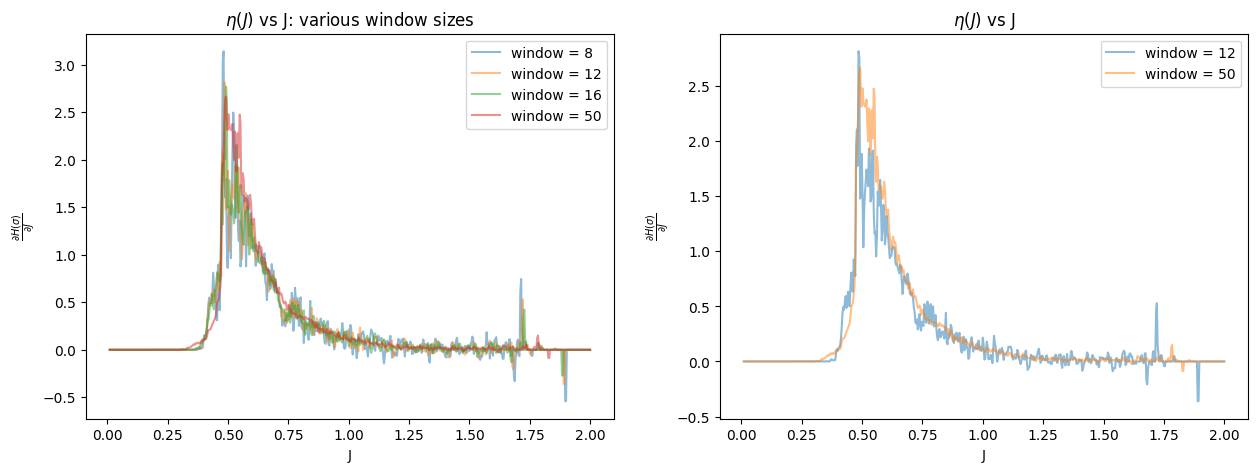

In [131]:
# try different window sizes, eta0100
eta8,_,_,_,_ = get_eta(etpSigma, fisherInfo, derivativeFilt=True, window=8)
# eta10,_,_,_,_ = get_eta(etpSigma, fisherInfo, derivativeFilt=True, window=10)
eta12,_,_,_,_ = get_eta(etpSigma, fisherInfo, derivativeFilt=True, window=12)
# eta14,_,_,_,_ = get_eta(etpSigma, fisherInfo, derivativeFilt=True, window=14)
eta16,_,_,_,_ = get_eta(etpSigma, fisherInfo, derivativeFilt=True, window=16)
eta50,_,_,_,_ = get_eta(etpSigma, fisherInfo, derivativeFilt=True, window=50)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(eta8.keys(), eta8.values(), label='window = 8',alpha=0.5)
# ax.plot(eta8.keys(), eta10.values(), label='window = 10',alpha=0.5)
ax.plot(eta8.keys(), eta12.values(), label='window = 12',alpha=0.5)
# ax.plot(eta8.keys(), eta14.values(), label='window = 14',alpha=0.5)
ax.plot(eta8.keys(), eta16.values(), label='window = 16',alpha=0.5)
ax.plot(eta8.keys(), eta50.values(), label='window = 50',alpha=0.5)
ax.set_title(r'$\eta(J)$ vs J: various window sizes');
ax.set_xlabel('J');
ax.set_ylabel(r'$\frac{\partial H(\sigma)}{\partial J}$');
ax.legend();

ax = axes[1]
ax.plot(eta8.keys(), eta12.values(), label='window = 12',alpha=0.5)
ax.plot(eta8.keys(), eta50.values(), label='window = 50',alpha=0.5)
ax.set_title(r'$\eta(J)$ vs J');
ax.set_xlabel('J');
ax.set_ylabel(r'$\frac{\partial H(\sigma)}{\partial J}$');
ax.legend();

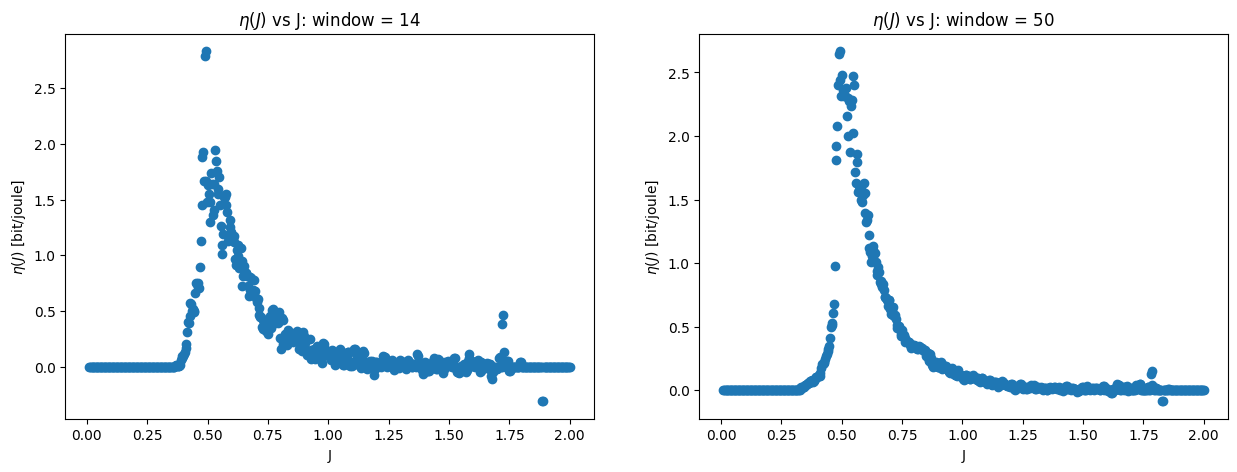

In [132]:
# compute thermodynamic efficiency
# thermodynamic efficiency
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.scatter(eta0100.keys(), eta0100.values())
ax.set_title(r'$\eta(J)$ vs J: window = 14');
ax.set_xlabel('J');
ax.set_ylabel(r'$\eta(J)$ [bit/joule]');
ax = axes[1]
ax.scatter(eta0100.keys(), eta50.values())
ax.set_title(r'$\eta(J)$ vs J: window = 50');
ax.set_xlabel('J');
ax.set_ylabel(r'$\eta(J)$ [bit/joule]');

etaSmooth = eta0100

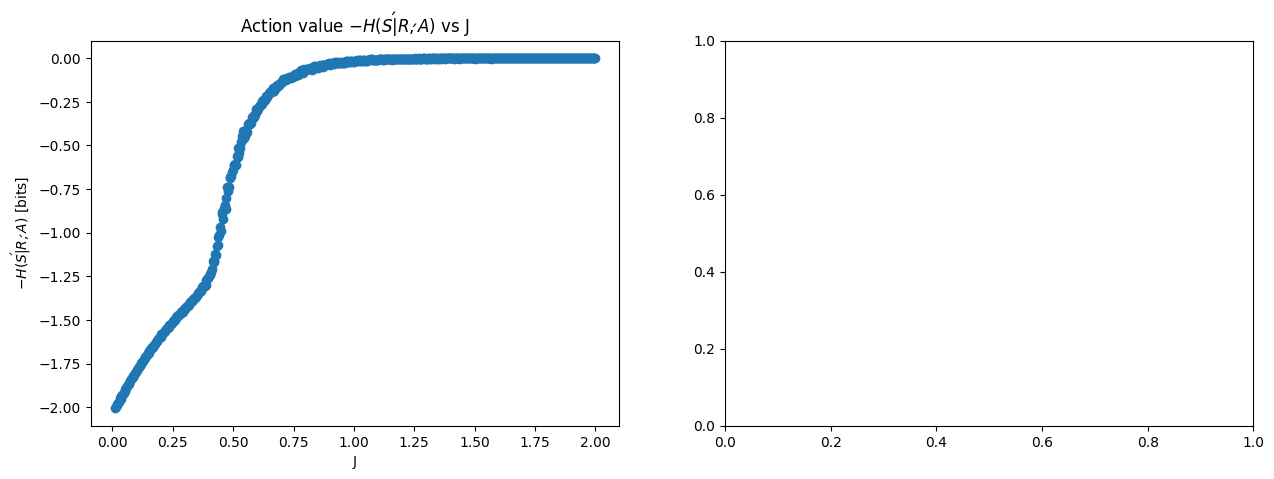

In [125]:
# plots for free energy
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.scatter(fe.keys(), fe.values())
ax.set_title(r'Action value $-H(S\'|R\',A)$ vs J');
ax.set_xlabel('J');
ax.set_ylabel(r'$-H(S\'|R\',A)$ [bits]');


In [ ]:
# make interactive plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(fiIntegrate.keys()), y=list(fiIntegrate.values()), name='integrate fi', mode='lines'))
fig.update_layout(title=r'Integration of fisher information $\int{F(J)}dJ$ vs J',
                  xaxis_title='J',
                  yaxis_title=r'$\int{F(J)}dJ$',
                  # autosize=False,  
                  # width=7*96,      
                  # height=5*96       
                  )
plot(fig, filename='integralfi.html', auto_open=True) 

In [133]:
# export data
output = pd.DataFrame({'pis':pis, 'etps':etps, 'emps':emps, 'mis':mis, 'etpSigma':etpSigma, 'fe':fe, 
                       'fisherInfo':fisherInfo, 'eta':etaSmooth})
output.index = pis.keys()
output.to_csv('./output_N100_dJ600_1200k.csv')

## plot exported data

In [142]:
results = pd.read_csv('./result240327_ising/output_N100_dJ600_1200k.csv')
results = results.rename(columns={"Unnamed: 0": "J"})
results.columns

Index(['J', 'pis', 'etps', 'emps', 'mis', 'etpSigma', 'fe', 'fisherInfo',
       'eta'],
      dtype='object')

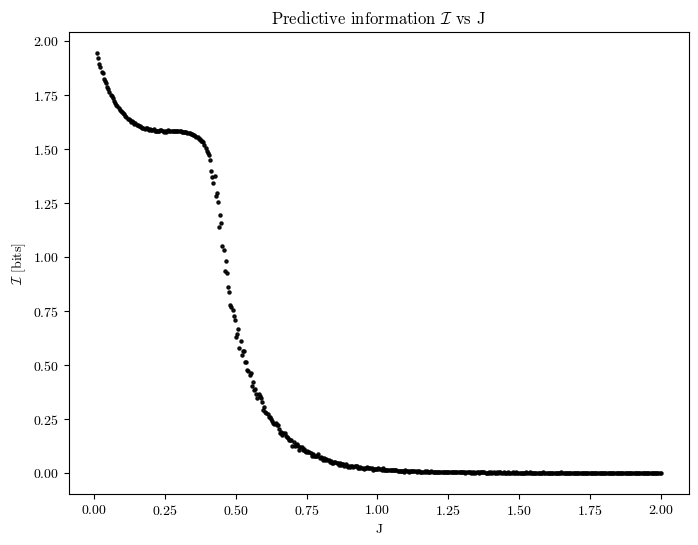

In [137]:
# predictive information
plt.figure(figsize=(8, 6))  # Define the figure size
plt.scatter(results['J'], results['pis'],s=5, color='k', alpha=0.9);
plt.title(r'Predictive information $\mathcal{I}$ vs J');
plt.ylabel(r'$\mathcal{I}$ [bits]');
plt.xlabel('J');
plt.savefig('pi_v_J.png', dpi=300)  # dpi=300 for high resolution

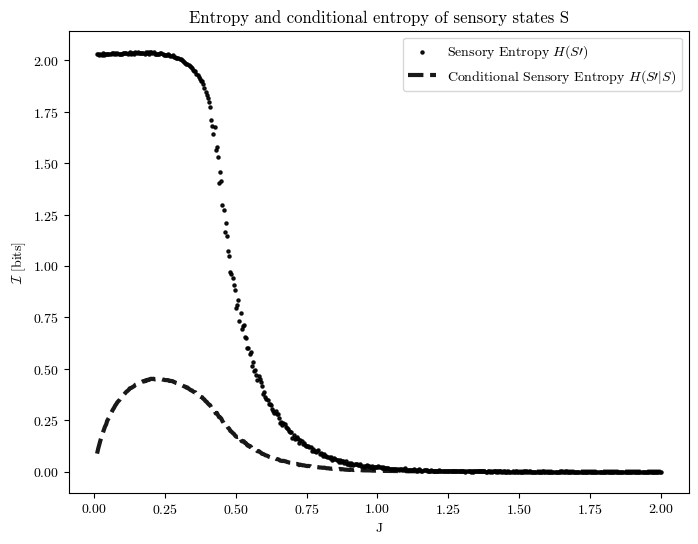

In [138]:
# decomposition of predictive information
plt.figure(figsize=(8, 6))  # Define the figure size
plt.scatter(results['J'], results['etps'], s=20,color='k', marker='.', alpha=0.9, label=r'Sensory Entropy $H(S\prime)$');
plt.plot(results['J'], results['etps'] - results['pis'],c='k', linewidth=3, linestyle='--', alpha=0.9, label=r'Conditional Sensory Entropy $H(S\prime|S)$');
plt.title('Entropy and conditional entropy of sensory states S');
plt.ylabel(r'$\mathcal{I}$ [bits]');
plt.xlabel('J');
plt.legend();
plt.savefig('hs_v_J.png', dpi=300)  # dpi=300 for high resolution

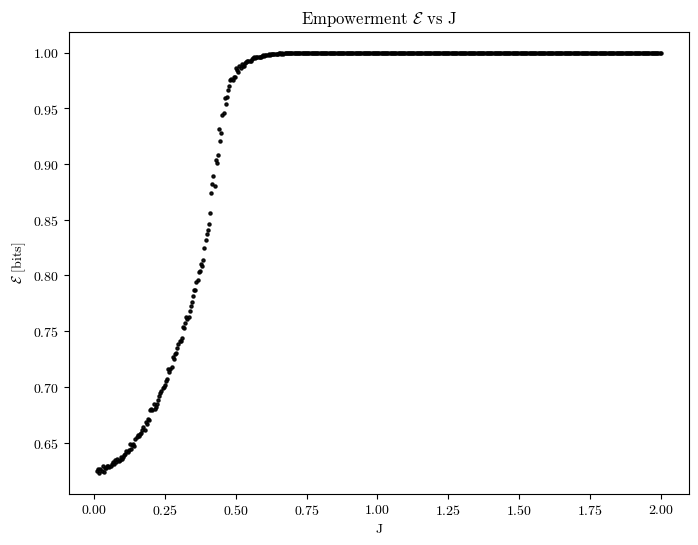

In [139]:
# empowerment
plt.figure(figsize=(8, 6))  # Define the figure size
plt.scatter(results['J'], results['emps'],s=5, color='k', alpha=0.9);
plt.title(r'Empowerment $\mathcal{E}$ vs J');
plt.ylabel(r'$\mathcal{E}$ [bits]');
plt.xlabel('J');
plt.savefig('emp_v_J.png', dpi=300)  # dpi=300 for high resolution

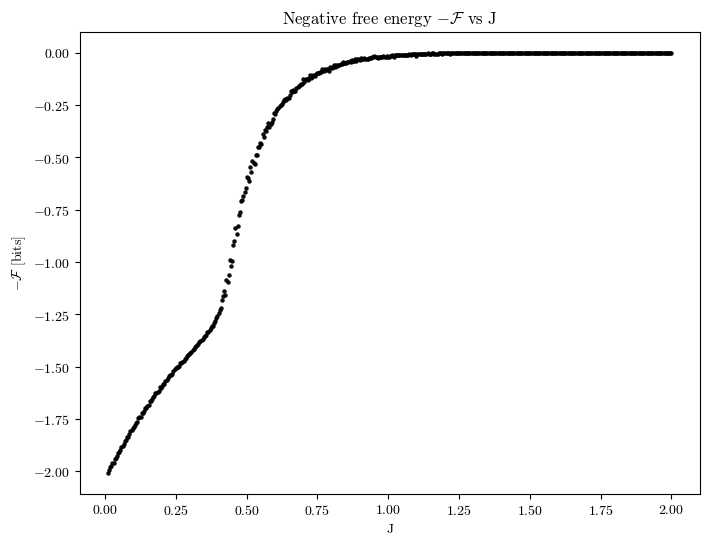

In [140]:
# free energy
plt.figure(figsize=(8, 6))  # Define the figure size
plt.scatter(results['J'], results['fe'],s=5, color='k', alpha=0.9);
plt.title(r'Negative free energy $-\mathcal{F}$ vs J');
plt.ylabel(r'$-\mathcal{F}$ [bits]');
plt.xlabel('J');
plt.savefig('nfe_v_J.png', dpi=300)  # dpi=300 for high resolution

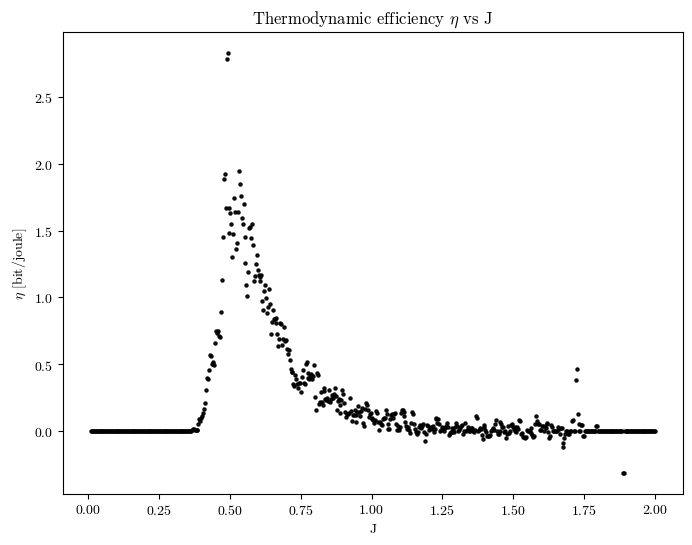

In [143]:
# Thermodynamic efficiency
plt.figure(figsize=(8, 6))  # Define the figure size
plt.scatter(results['J'], results['eta'],s=5, color='k', alpha=0.9);
plt.title(r'Thermodynamic efficiency $\eta$ vs J');
plt.ylabel(r'$\eta$ [bit/joule]');
plt.xlabel('J');
plt.savefig('eta_v_J.png', dpi=300)  # dpi=300 for high resolution